# Import libraries

In [ ]:
# mamba install gpy
# mamba install richdem

In [ ]:
pip install tensorflow

In [ ]:
pip install parameter-sherpa

In [ ]:
pip install shap

In [91]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import pandas as pd
import scipy.io as sio
from scipy import stats
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
import tensorflow
import io
import os
from PIL import Image
import seaborn as sns
import richdem as rd

import tensorflow as tf
import tensorflow.math
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Input
from sherpa import multiprocessing

import shap

plt.rcParams['figure.figsize'] = (12,12)

# Load MAR output

#### Load local MAR output for 2020 on 6.5km

In [52]:
url = 'gs://leap-persistent/raf-antwerpen/MARv3.12-6_5km-daily-ERA5-2020.zarr'
ds2020 = xr.open_dataset(url, engine='zarr', chunks={})

In [53]:
jun1 = 151
aug31 = 242
numberdays = aug31-jun1+1
jun1_leap = jun1 + 1
aug31_leap = aug31 + 1

numberyears = 22
numberdaystot = numberyears * numberdays
n_feature = 20
n_lat = 415
n_lon = 230

In [54]:
LAT = ds2020.LAT.values
LON = ds2020.LON.values
AL2_2020 = ds2020.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]

In [55]:
SH_vals = rd.rdarray(ds2020.SH.values, no_data=-9999)

slope = rd.TerrainAttribute(SH_vals, attrib='slope_riserun')
aspect = rd.TerrainAttribute(SH_vals, attrib='aspect')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (rise/run)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.00271395===================== ] (99% - 0.0s - 1 threads)                                    ] (13% - 0.0s - 1 threads)

A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.00477292===================== ] (99% - 0.0s - 1 threads)


In [56]:
alg2016 = np.flipud(np.array(Image.open('./algae2016_MARproj_6_5km.tif')))
alg2017 = np.flipud(np.array(Image.open('./algae2017_MARproj_6_5km.tif')))
alg2016 = np.where(alg2016 == 0, np.nan, alg2016)
alg2017 = np.where(alg2017 == 0, np.nan, alg2017)

algnan = np.zeros((415,230))
algnan = np.where(algnan == 0, np.nan, np.nan)

In [57]:
# x = np.zeros((numberyears, numberdays, n_lat, n_lon, n_feature))

# for i in range(22):
   
#     year = i + 2000
#     url = f"gs://leap-persistent/raf-antwerpen/MARv3.12-6_5km-daily-ERA5-{year}.zarr"
#     ds = xr.open_dataset(url, engine='zarr', chunks={})
    
#     x[i,:,:,:,0] = ds.ST2.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     x[i,:,:,:,1] = ds.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,2] = ds.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,3] = ds.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,4] = ds.LWD.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,5] = ds.SHF.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,6] = ds.LHF.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,7] = ds.SP.values[jun1:aug31+1,:n_lat,:n_lon]
#     x[i,:,:,:,8] = np.mean(ds.RO1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
#     x[i,:,:,:,9] = ds.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     x[i,:,:,:,10] = ds.UU.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     x[i,:,:,:,11] = ds.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     x[i,:,:,:,12] = ds.SU.values[jun1:aug31+1,0,:n_lat,:n_lon]
#     x[i,:,:,:,13] = np.mean(ds.WA1.values[jun1:aug31+1,0:9,:n_lat,:n_lon], 1) # average of top 1m
#     x[i,:,:,:,14] = ds.SF.values[jun1:aug31+1,:n_lat,:n_lon]
#     # repeat the same data for each day for SH, SOL, slope, aspect, algnan since they do not vary temporally.
#     for j in range(aug31-jun1+1):
#         x[i,j,:,:,15] = ds2020.SH.values[:n_lat,:n_lon]
#         x[i,j,:,:,16] = ds2020.SOL.values[:n_lat,:n_lon]
#         x[i,j,:,:,17] = slope[:n_lat,:n_lon]
#         x[i,j,:,:,18] = aspect[:n_lat,:n_lon]
#         x[i,j,:,:,19] = algnan

# for k in range(aug31-jun1+1):
#     x[16,k,:,:,19] = alg2016
#     x[17,k,:,:,19] = alg2017

In [58]:
x = np.zeros((numberyears, numberdays, n_lat, n_lon, 3))

for i in range(22):
   
    year = i + 2000
    url = f"gs://leap-persistent/raf-antwerpen/MARv3.12-6_5km-daily-ERA5-{year}.zarr"
    ds = xr.open_dataset(url, engine='zarr', chunks={})
    
    # x[i,:,:,:,0] = ds.SWU.values[jun1:aug31+1,:n_lat,:n_lon]
    # x[i,:,:,:,1] = ds.SWD.values[jun1:aug31+1,:n_lat,:n_lon]
    # x[i,:,:,:,2] = ds.LWU.values[jun1:aug31+1,:n_lat,:n_lon]
    # x[i,:,:,:,3] = ds.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]
    # x[i,:,:,:,4] = ds.VV.values[jun1:aug31+1,0,:n_lat,:n_lon]
    x[i,:,:,:,0] = ds.RU.values[jun1:aug31+1,0,:n_lat,:n_lon]
    # # repeat the same data for each day for SH, SOL, slope, aspect, algnan since they do not vary temporally.
    for j in range(aug31-jun1+1):
        x[i,j,:,:,1] = ds2020.SH.values[:n_lat,:n_lon]
        x[i,j,:,:,2] = slope[:n_lat,:n_lon]
        # x[i,j,:,:,7] = aspect[:n_lat,:n_lon]
        

In [59]:
# use only lower half
# x = x[:,:,:int(n_lat/2),:,:]
# x = x.reshape(numberdaystot, int(n_lat/2), n_lon, 3)

# use only lower left quadrant
x = x[:,:,:int(n_lat/2),:int(n_lon/2),:]
x = x.reshape(numberdaystot, int(n_lat/2), int(n_lon/2), 3)

In [60]:
np.shape(x)

(2024, 207, 115, 3)

In [13]:
# np.save('x.npy', x)

# Load MODIS albedo data

#### Load MODIS albedo data for June, July, and August in 2020

In [61]:
path = './MOD10A1_albedo_MARproj_6_5km/'
dir_list = np.sort(os.listdir(path))
dir_list = dir_list[:]
dir_list

array(['20000601_albedo.tif', '20000602_albedo.tif',
       '20000603_albedo.tif', ..., '20210829_albedo.tif',
       '20210830_albedo.tif', '20210831_albedo.tif'], dtype='<U19')

#### Create nan arrays for days where I don't have MODIS data

In [62]:
modisnan = np.zeros((415,230))
modisnan = np.where(modisnan == 0, np.nan, np.nan)

#### Flip matrix right-side up and place in new matrix 'y'

In [63]:
y = np.zeros((numberdaystot,415,230,1))

for i in range(65):
    f = dir_list[i]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

for i in range(65,78):
    y[i,:,:,0] = modisnan

for i in range(78,107):
    f = dir_list[i-13]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

for i in range(107,124):
    y[i,:,:,0] = modisnan

for i in range(124,numberdaystot):
    f = dir_list[i-29]
    im = Image.open(path + f)
    y[i,:,:,0] = np.flipud(np.array(im))

#### Turn 255's into NaNs, divide by 100 to get albedo in 0-1 range, and multiply with bare ice matrix to extract only bare ice albedo values

In [64]:
y = np.where(y == 255, np.nan, y)
y = y/100

#### Load bare ice variable (from Antwerpen et al., 2022). This variables gives 1's for bare ice and NaNs for non-bare ice (snow, land, or ocean) daily for June, July, and August in 2000-2021

In [65]:
ds_bie = sio.loadmat('./sboth_6km.mat')
bareice = np.flipud(ds_bie['sboth_6km'])
bareice = np.transpose(bareice, (2, 3, 0, 1))
bareice = bareice.reshape(numberdaystot, n_lat, n_lon)

#### Multiply with bare ice matrix to extract only bare ice albedo values

In [66]:
y = y[:,:,:,0] * bareice

#### Only use southern half or southwest quadrant

In [67]:
# use only lower half
# y = y[:,:int(n_lat/2),:]

# use only lower left quadrant
y = y[:,:int(n_lat/2),:int(n_lon/2)]

In [21]:
# np.save('y.npy', y)

# Only run if looking at difference between observed and modeled albedo

In [10]:
# y = y - ds.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon]

# Correlation matrix for MAR variables

In [24]:
# x_flat = x.reshape(1104*207*100, 20)
x_flat = x.reshape(2024*207*115, 3)

In [25]:
# df = pd.DataFrame(x_flat, columns = ['ST2', 'SWU', 'SWD', 'LWU', 'LWD', 'SHF', 'LHF', 'SP', 'RO1', 'AL2', 'UU', 'VV', 'SU', 'WA1', 'SF', 'SH', 'SOL', 'slope', 'aspect', 'algae'])
df = pd.DataFrame(x_flat, columns = ['RU', 'SH', 'slope'])

In [26]:
# add MODIS albedo to dataframe
y_flat = y.reshape(2024*207*115, 1)
df['MODIS albedo'] = y_flat

In [27]:
corrmat = df.corr()

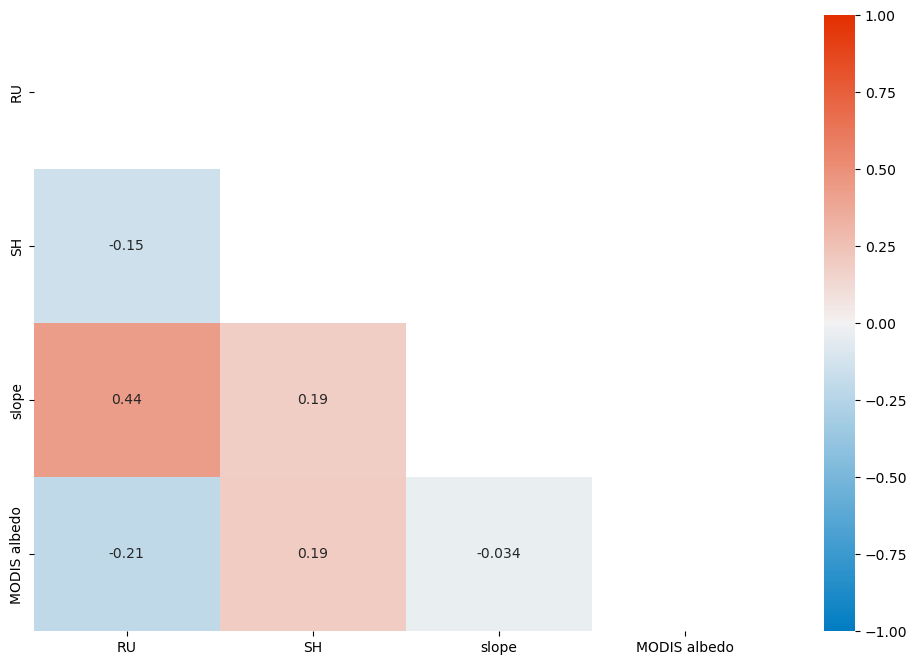

In [28]:
plt.figure(figsize=(12,8))

cmap = sns.diverging_palette(245, 15, s=100, as_cmap=True)
mask = np.triu(np.ones_like(corrmat, dtype=bool))

sns.heatmap(corrmat, annot=True, mask=mask, cmap=cmap, vmin=-1, vmax=1);

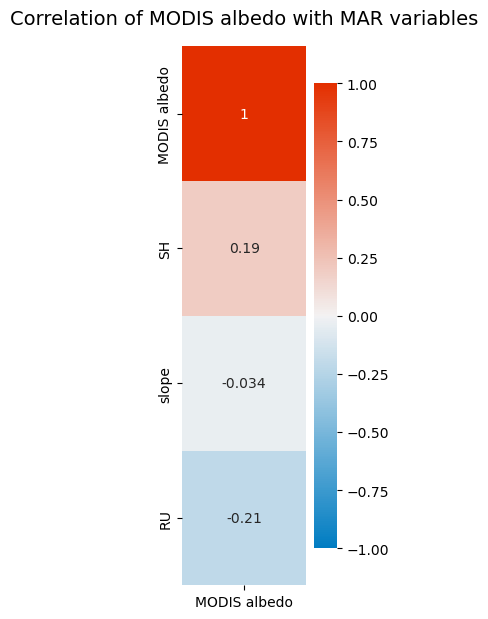

In [29]:
plt.figure(figsize=(2, 7))
heatmap = sns.heatmap(corrmat[['MODIS albedo']].sort_values(by='MODIS albedo', ascending=False), vmin=-1, vmax=1, annot=True, cmap=cmap)
heatmap.set_title('Correlation of MODIS albedo with MAR variables', fontdict={'fontsize':14}, pad=16);

# Prepare data for training and testing

#### Standardize the data so all values are in the 0-range, plusminus a couple (2-5).

In [68]:
x_dum = np.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3]))
for i in range(x.shape[3]):
    
    mean, std = np.nanmean(x[:,:,:,i]), np.nanstd(x[:,:,:,i])
        
    x_dum[:,:,:,i]   = (x[:,:,:,i] - mean)/std
    
    # if i == 9:
        # AL2_mean, AL2_std = np.nanmean(x[:,:,:,i]), np.nanstd(x[:,:,:,i])

x = x_dum

In [81]:
# # normalize between 0 and 1

# x_dum = np.zeros((x.shape[0], x.shape[1], x.shape[2], x.shape[3]))
# for i in range(x.shape[3]):
        
#     x_dum[:,:,:,i] = (x[:,:,:,i] - np.nanmin(x[:,:,:,i])) / (np.nanmax(x[:,:,:,i]) - np.nanmin(x[:,:,:,i]))

# x = x_dum

In [ ]:
# below two cells are to only include albedos > 0.1 but it needs some work with dimensions

In [15]:
# y_masknan = np.where(y > 0.1, 1, np.nan)
# y_mask = y * y_masknan
# x_mask = np.zeros((numberdaystot,207,100,17))
# for i in range(17):
    # x_mask[:,:,:,i] = x[:,:,:,i] * y_masknan[:,:,:]

In [18]:
# y_nonan = y_mask[~np.isnan(y_mask)]
# 
# x_nonan = np.zeros((117412,17))
# 
# for i in range(17):
    # x_mask_dum = x_mask[:,:,:,i]
    # x_nonan[:,i] = x_mask_dum[~np.isnan(x_mask_dum)]

#### Now the data is split into 11 years (training1) and 1 year (testing). Change this once I include more years!
#### dDon't shuffle the data

In [69]:
X_train1, X_test, y_train1, y_test = train_test_split(x, y, test_size=(2/22), shuffle=False)

In [70]:
X_train1.shape, X_test.shape, y_train1.shape, y_test.shape

((1840, 207, 115, 3), (184, 207, 115, 3), (1840, 207, 115), (184, 207, 115))

#### Now the data is further split into 10 years (training) and 1 year (validation). Change this once I include more years!
#### Don't shuffle the data

In [71]:
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=(2/20), shuffle=False)

In [72]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1656, 207, 115, 3), (184, 207, 115, 3), (1656, 207, 115), (184, 207, 115))

#### Replace NaNs in output with arbitrary -10's. This is so the custom loss function can ignore these non-bare ice pixels

In [73]:
y_train = np.where(np.isnan(y_train), -10, y_train)
y_val = np.where(np.isnan(y_val), -10, y_val)
y_test = np.where(np.isnan(y_test), -10, y_test)

#### Add dummy dimension of size 1 in dimension number 1 to X_train and X_test. This is so the CNN-LSTM can work with the data

In [74]:
X_train_dum = np.zeros((X_train.shape[0], 1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))
X_train_dum[:,0,:,:,:] = X_train
X_train = X_train_dum

X_val_dum = np.zeros((X_val.shape[0], 1, X_val.shape[1], X_val.shape[2], X_val.shape[3]))
X_val_dum[:,0,:,:,:] = X_val
X_val = X_val_dum

X_test_dum = np.zeros((X_test.shape[0], 1, X_test.shape[1], X_test.shape[2], X_test.shape[3]))
X_test_dum[:,0,:,:,:] = X_test
X_test = X_test_dum

In [75]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1656, 1, 207, 115, 3),
 (1656, 207, 115),
 (184, 1, 207, 115, 3),
 (184, 207, 115),
 (184, 1, 207, 115, 3),
 (184, 207, 115))

# Initialize and run CNN-LSTM model

#### Define custom loss function. This is a regular mean squared error (MSE) loss function. But it will only return a value when the predictant (MODIS albedo) is higher than -9, so the CNN-LSTM will only train on the bare ice pixels and ignore the other pixels

In [76]:
def my_loss_fn(y_true, y_pred):
    
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    y_true_mask = tf.cast(tf.where(y_true > -9, 1, 0), dtype=tf.float32)
    # y_true_mask = tf.cast(tf.where(y_true > 0, 1, 0), dtype=tf.float32)

    squared_difference = tf.multiply(tf.square(y_true - y_pred), y_true_mask) / tf.math.reduce_sum(y_true_mask)
    
    # return tf.reduce_mean(squared_difference, axis=-1)
    return squared_difference                              # try witout reduce mean

In [495]:
# # add physical constraint that y_pred has to be above 0.05

# def my_loss_fn(y_true, y_pred):
    
#     y_true = tf.cast(y_true, dtype=tf.float32)
#     y_pred = tf.cast(y_pred, dtype=tf.float32)
    
#     y_true_mask = tf.cast(tf.where(y_true > -9, 1, 0), dtype=tf.float32)
    
#     y_pred_mask = tf.cast(tf.where(y_pred > 0.05, 1, 0), dtype=tf.float32)
    
#     y_true_pred_mask = y_true_mask * y_pred_mask
    
#     squared_difference = tf.multiply(tf.square(y_true - y_pred), y_true_mask) / tf.math.reduce_sum(y_true_mask)
#     squared_difference = tf.math.reduce_sum(tf.square(tf.multiply(y_true, y_true_mask) - tf.multiply(y_pred, y_pred_mask))) / tf.math.reduce_sum(y_true_pred_mask)
    
#     return tf.reduce_mean(squared_difference, axis=-1)
#     # return squared_difference

# Hyperparameter tuning with Sherpa

In [ ]:
multiprocessing.set_start_method("fork")

In [192]:
parameters = [sherpa.Ordinal('learning_rate', range=[0.01, 0.1, 1]), #10, 1000]
              sherpa.Ordinal('dropout_rate', range=[0.25, 0.5, 0.75]),
              sherpa.Ordinal('kernel_size', range=[3, 5, 7]),
              sherpa.Ordinal('batch_size', range=[8, 16, 32]),
              sherpa.Ordinal('n_lstm_unit1', range=[10, 30, 50]),
              sherpa.Ordinal('n_lstm_unit2', range=[5, 10, 15]),
              sherpa.Ordinal('n_filters', range=[10, 30, 50]),
              sherpa.Ordinal('pool_size', range=[2, 4, 8]),
              sherpa.Choice(name='activation', range=['relu'])
              sherpa.Choice(name='metric', range=['accuracy', 'val_loss', 'mean_squared_error'])]

alg = sherpa.algorithms.RandomSearch(max_num_trials=10000)

In [ ]:
study = sherpa.Study(parameters=parameters,
                     algorithm=alg,
                     lower_is_better=True)

In [ ]:
for trial in study:
    
    model = Sequential()
    
    model.add(Dropout(trial.parameters['dropout_rate']))

    model.add(Input(shape=(1, n_lat, n_lon, n_feature)))

    model.add(TimeDistributed(Conv2D(trial.parameters['n_filters'],
                                     (trial.parameters['kernel_size'], trial.parameters['kernel_size']), 
                                     padding='same',
                                     activation=trial.parameters['activation']),
                              input_shape=(1, n_lat, n_lon, n_feature)))

    model.add(TimeDistributed(AveragePooling2D(trial.parameters['pool_size'])))
    model.add(TimeDistributed(GlobalAveragePooling2D()))

    model.add(LSTM(trial.parameters['n_lstm_unit1'], activation=trial.parameters['activation'], return_sequences=True))
    model.add(LSTM(trial.parameters['n_lstm_unit2'], activation=trial.parameters['activation']))
    
    model.add(Dense(n_lat*n_lon))
    model.add(Activation('linear'))
    model.add(Reshape((n_lat, n_lon)))

    model.compile(loss=my_loss_fn,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=trial.parameters['learning_rate']),
                  metrics=['accuracy'])
        
    model.fit(X_train, y_train,
              epochs=20,
              batch_size=trial.parameters['batch_size'],
              verbose=1,
              validation_data=(X_val, y_val),
              callbacks=[study.keras_callback(trial, objective_name='val_loss')])
              # callbacks=[study.keras_callback(trial, objective_name=trial.parameters['metric'])])
    
    study.finalize(trial)

In [ ]:
study.get_best_result()

# Set hyperparameters for CNN-LSTM

In [77]:
n_filters      = 250 #250 # number of filters
kernel_size    = 5 #3  # kernel size for convolutional layers
pool_size      = 16  # size for average pooling layers
n_lstm_unit1   = 50 #25 # number of LSTM units
n_lstm_unit2   = 25 # number of LSTM units
drop_out       = 0.25

activation     = 'relu' # activation function
learning_rate  = 1  #0.1  # learning rate
minibatch_size = 32 #32   # batch size
num_epochs     = 150 #50   # number of total epochs

In [39]:
# n_filters      = 20 # number of filters
# kernel_size    = 3  # kernel size for convolutional layers
# pool_size      = 8  # size for average pooling layers
# n_lstm_unit1    = 25 # number of LSTM units
# n_lstm_unit2    = 10 # number of LSTM units

# activation     = 'relu' # activation function
# learning_rate  = 1 #100   # learning rate
# minibatch_size = 100   # batch size
# num_epochs     = 30   # number of total epochs

In [217]:
# The number of data points I use is 22y*92d*207lat*100lon*19feature = ~800,000,000
# The number of trainable parameters should be about 10-30 less than the number of data points
# So, about 27,000,000-80,000,000 of trainable parameters

# Set up CNN-LSTM model

In [78]:
n_lat_model = 207
n_lon_model = 115
n_feature_model = 3

In [ ]:
# model = Sequential()

# # model.add(Input(shape=(1, n_lat_model, n_lon_model, n_feature_model+1)))
# model.add(Input(shape=(1, n_lat_model, n_lon_model, n_feature_model)))

# # model.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
# #                                      padding='same', activation=activation), input_shape=(1, n_lat_model, n_lon_model, n_feature_model+1)))
# model.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
#                                      padding='same', activation=activation), input_shape=(1, n_lat_model, n_lon_model, n_feature_model)))

# model.add(TimeDistributed(AveragePooling2D(pool_size)))
# model.add(TimeDistributed(GlobalAveragePooling2D()))

# model.add(Dense(n_lat_model*n_lon_model)) # add dense between lstm's or cnn's ? or multiple in a raw to increase number of params.

# model.add(LSTM(n_lstm_unit1, activation=activation, return_sequences=True))
# # model.add(Dense(n_lat*n _lon)) # add dense between lstm's or cnn's ? or multiple in a raw to increase number of params.
# # model.add(LSTM(n_lstm_unit2, activation=activation)) # try without

# model.add(Activation('linear'))
# # model.add(Dense(n_lat_model*n_lon_model)) # add dense between lstm's or cnn's ? or multiple in a raw to increase number of params.

# model.add(Dropout(drop_out)) # play around with location

# model.add(Reshape((n_lat_model, n_lon_model)))

# model.compile(loss=my_loss_fn, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)) #, metrics=['val_loss'])
# # model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=[tf.keras.metrics.MeanSquaredError()])

# model.summary()

In [79]:
model = Sequential()

model.add(Input(shape=(1, n_lat_model, n_lon_model, n_feature_model)))

model.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
                                     padding='same', activation=activation), input_shape=(1, n_lat_model, n_lon_model, n_feature_model)))

model.add(TimeDistributed(AveragePooling2D(pool_size)))
model.add(TimeDistributed(GlobalAveragePooling2D()))

model.add(LSTM(n_lstm_unit1, activation=activation, return_sequences=True))
model.add(LSTM(n_lstm_unit2, activation=activation))

model.add(Dense(n_lat_model*n_lon_model))
model.add(Activation('linear'))
model.add(Reshape((n_lat_model, n_lon_model)))

model.compile(loss=my_loss_fn, optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, 1, 207, 115, 250   19000     
 stributed)                  )                                   
                                                                 
 time_distributed_4 (TimeDi  (None, 1, 12, 7, 250)     0         
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, 1, 250)            0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             60200     
                                                                 
 lstm_3 (LSTM)               (None, 25)                7600      
                                                      

#### Fit CNN-LSTM model

In [80]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train, 
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    verbose=1,
                    callbacks=[early_stop],
                    validation_data =(X_val, y_val))

Epoch 1/150
52/52 [==============================] - 22s 379ms/step - loss: 2.2808e-07 - accuracy: 0.1400 - val_loss: 1.8020e-07 - val_accuracy: 0.1442
Epoch 2/150
52/52 [==============================] - 20s 377ms/step - loss: 1.4396e-07 - accuracy: 0.1445 - val_loss: 1.0012e-07 - val_accuracy: 0.1452
Epoch 3/150
52/52 [==============================] - 19s 374ms/step - loss: 8.7940e-08 - accuracy: 0.1457 - val_loss: 6.2427e-08 - val_accuracy: 0.1468
Epoch 4/150
52/52 [==============================] - 19s 372ms/step - loss: 5.8676e-08 - accuracy: 0.1445 - val_loss: 4.5392e-08 - val_accuracy: 0.1446
Epoch 5/150
52/52 [==============================] - 19s 373ms/step - loss: 4.3548e-08 - accuracy: 0.1427 - val_loss: 3.6838e-08 - val_accuracy: 0.1413
Epoch 6/150
52/52 [==============================] - 19s 373ms/step - loss: 3.4451e-08 - accuracy: 0.1351 - val_loss: 3.1926e-08 - val_accuracy: 0.1339
Epoch 7/150
52/52 [==============================] - 19s 374ms/step - loss: 2.8746e-08 -

#### Summarize history for loss

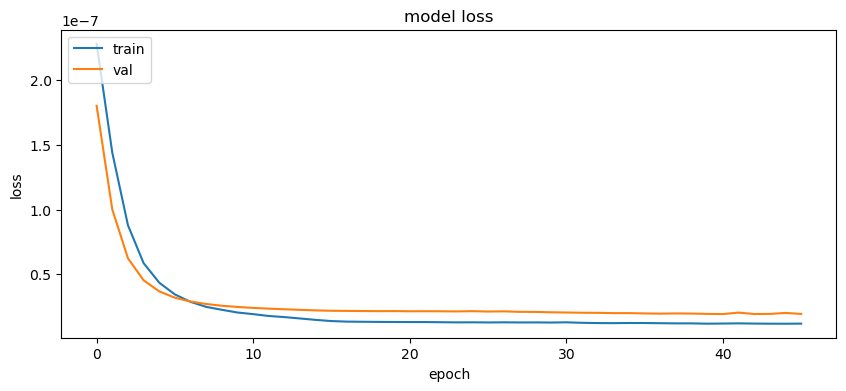

In [81]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

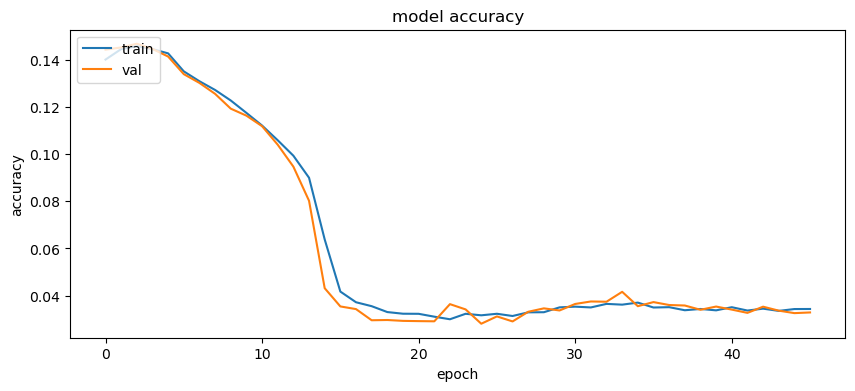

In [82]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Calculate CNN-LSTM albedo predictions

In [83]:
y_test_pred = model.predict(X_test)
y_test_pred = y_test_pred.reshape(y_test_pred.shape[0], X_train.shape[2], X_train.shape[3])

6/6 [==============================] - 1s 50ms/step


#### Turn non-bare ice pixels from -10's back into NaNs. This is for visualization

In [84]:
y_test_pred = np.where(y_test == -10, np.nan, y_test_pred)
y_test = np.where(y_test == -10, np.nan, y_test)

In [85]:
np.nanmean(y_test), np.nanmean(y_test_pred)

(0.40884643459437664, 0.4270764)

### R^2 between observed and predicted (CNN-LSTM) ice albedo

In [86]:
y_test_flat = y_test.flatten()
select = np.where(~np.isnan(y_test_flat))
y_test_nonnan = y_test_flat[select]

y_test_pred_flat = y_test_pred.flatten()
select_pred = np.where(~np.isnan(y_test_pred_flat))
y_test_pred_nonnan = y_test_pred_flat[select]

In [87]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test_nonnan, y_test_pred_nonnan)
slope, intercept, r_value, p_value, std_err

(0.34515996147083233,
 0.2859586518886959,
 0.5994023379235827,
 0.0,
 0.0023125554904071094)

In [88]:
R2 = r_value**2
R2

0.3592831627082568

### MSE of MODIS and CNN-LSTM albedo

In [107]:
# not good, delete this!
# MSE1 = (np.nansum((np.nanmean(y_test, 0) - np.nanmean(y_test_pred, 0))**2)) / np.sum(~np.isnan(np.nanmean(y_test, 0)))
# MSE1

0.003470802826229768

In [113]:
mean_squared_error(np.ravel(y_test[~np.isnan(y_test)]), np.ravel(y_test_pred[~np.isnan(y_test_pred)]))

0.012562580265219243

In [114]:
# RMSE percentage
rmspe = np.sqrt(np.nanmean(np.square(((y_test[~np.isnan(y_test)] - y_test_pred[~np.isnan(y_test_pred)]) / y_test[~np.isnan(y_test)])), axis=0))
rmspe

2.7774393082453246

### R^2 and MSE between observed and predicted (MAR) ice albedo

In [ ]:
# AL2_2019 = ds2019.AL2.values[jun1:aug31+1,0,:n_lat,:n_lon] * np.where(y_test[:92,:n_lat,:n_lon] > -8, 1, np.nan)
# AL2_2020 = ds2020.AL2.values[jun1_leap:aug31_leap+1,0,:n_lat,:n_lon] * np.where(y_test[:,:n_lat,:n_lon] > -8, 1, np.nan)

In [ ]:
# AL2_1920 = np.zeros((184, 207, 100))
# AL2_1920[:92,:,:] = AL2_2019
# AL2_1920[92:,:,:] = AL2_2020

In [ ]:
R2_2 = ma.corrcoef(ma.masked_invalid(y_test.flatten()), ma.masked_invalid(AL2_2020.flatten()))[1,0]**2
R2_2

In [ ]:
MSE2 = (np.nansum((np.nanmean(y_test, 0) - (np.nanmean(AL2_2020, 0) * np.where(np.nanmean(y_test[:,:n_lat,:n_lon], 0) > -8, 1, np.nan)))**2)) / np.sum(~np.isnan(np.nanmean(y_test, 0)))
MSE2

# Visualization

#### Map plots of observed ice albedo (left), predicted ice albedo (middle), and their difference (right)

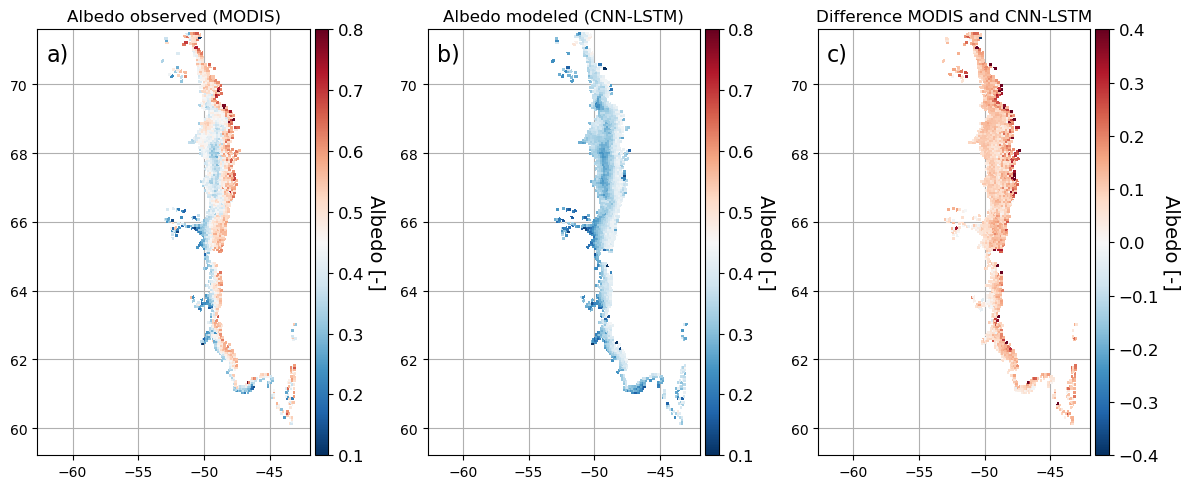

In [56]:
fig = plt.figure(figsize=(12, 5))

cmap = 'RdBu_r'

ax1 = fig.add_subplot(131)
# p1 = ax1.pcolor(ds2020.LON.values[:n_lat,:n_lon], ds2020.LAT.values[:n_lat,:n_lon], np.nanmean(y_test, 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
p1 = ax1.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(y_test, 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
ax1.text(-62, 70.7, 'a)', fontsize=16)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar1 = fig.colorbar(p1, cax=cax, orientation='vertical')
cbar1.set_label('Albedo [-]', rotation=270, fontsize=14)
cbar1.ax.tick_params(labelsize=12)
cbar1.ax.get_yaxis().labelpad = 15
ax1.grid(zorder=1)
ax1.set_title('Albedo observed (MODIS)')

ax2 = fig.add_subplot(132)
# p2 = ax2.pcolor(ds2020.LON.values[:n_lat,:n_lon], ds2020.LAT.values[:n_lat,:n_lon], np.nanmean(y_test_pred, 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
p2 = ax2.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(y_test_pred, 0), cmap=cmap, zorder=2, vmin=0.1, vmax=0.8)
ax2.text(-62, 70.7, 'b)', fontsize=16)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar2 = fig.colorbar(p2, cax=cax, orientation='vertical')
cbar2.set_label('Albedo [-]', rotation=270, fontsize=14)
cbar2.ax.tick_params(labelsize=12)
cbar2.ax.get_yaxis().labelpad = 15
ax2.grid(zorder=1)
ax2.set_title('Albedo modeled (CNN-LSTM)')

ax3 = fig.add_subplot(133)
p3 = ax3.pcolor(LON[:n_lat_model,:n_lon_model], LAT[:n_lat_model,:n_lon_model], np.nanmean(y_test, 0) - np.nanmean(y_test_pred, 0), cmap=cmap, zorder=2, vmin=-0.4 ,vmax=0.4)
ax3.text(-62, 70.7, 'c)', fontsize=16)
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar3 = fig.colorbar(p3, cax=cax, orientation='vertical')
cbar3.set_label('Albedo [-]', rotation=270, fontsize=14)
cbar3.ax.tick_params(labelsize=12)
cbar3.ax.get_yaxis().labelpad = 15
ax3.grid(zorder=1)
ax3.set_title('Difference MODIS and CNN-LSTM')

plt.tight_layout()

## Scatterplot of MODIS and CNN-LSTM albedo --> for just albedo

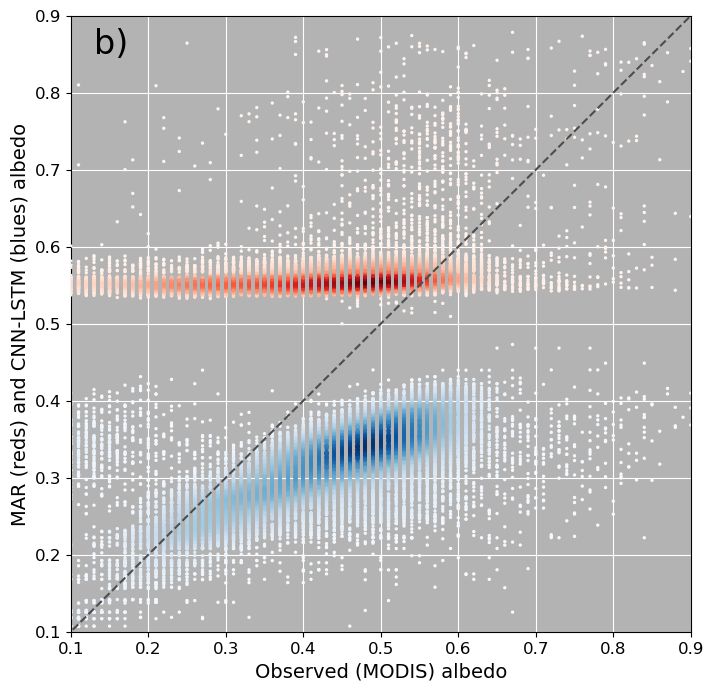

In [109]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca()

select = ~np.isnan(y_test)
select_pred = ~np.isnan(y_test_pred)
select_AL2 = ~np.isnan(AL2_2020)
y_test_plot = y_test[select]
y_test_pred_plot = y_test_pred[select_pred]
AL2_plot = AL2_2020[select_AL2]


# Calculate the point density
xy1 = np.vstack([y_test_plot, y_test_pred_plot])
z1 = gaussian_kde(xy1)(xy1)
xy2 = np.vstack([y_test_plot, AL2_plot])
z2 = gaussian_kde(xy2)(xy2)

plt.plot(np.arange(-1,1,0.1), np.arange(-1,1,0.1), color=[0.3, 0.3, 0.3], linestyle='--', linewidth=1.5, zorder=4)
plt.scatter(y_test_plot, y_test_pred_plot, c=z1, s=2, zorder=2, cmap='Blues')
plt.scatter(y_test_plot, AL2_plot, c=z2, s=2, zorder=3, cmap='Reds')
ax.text(0.13, 0.85, 'b)', fontsize=24)

plt.xlabel('Observed (MODIS) albedo', fontsize=14)
plt.ylabel('MAR (reds) and CNN-LSTM (blues) albedo', fontsize=14)
plt.grid(color='w', zorder=1)
ax.set_facecolor([0.7, 0.7, 0.7])
plt.tick_params(labelsize=12)
plt.xlim(0.1, 0.9);
plt.ylim(0.1, 0.9);

## Scatterplot of MODIS and CNN-LSTM albedo --> for difference in albedo between model and observation

0.07169590698279893

#### Time series of average albedo throughout 2020

/tmp/ipykernel_944/1689337231.py:2: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(np.nanmean(y_test, 2), 1), label='y test')
/tmp/ipykernel_944/1689337231.py:3: RuntimeWarning: Mean of empty slice
  plt.plot(np.nanmean(np.nanmean(y_test_pred, 2), 1), label='y test predicted')


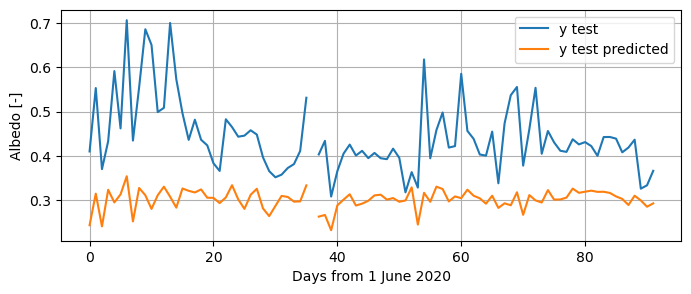

In [67]:
plt.figure(figsize=(8,3))
plt.plot(np.nanmean(np.nanmean(y_test, 2), 1), label='y test')
plt.plot(np.nanmean(np.nanmean(y_test_pred, 2), 1), label='y test predicted')
plt.xlabel('Days from 1 June 2020')
plt.ylabel('Albedo [-]')
plt.legend()
plt.grid()

#### Calculation and map plot of average R^2 per pixel in the study domain

In [45]:
corrmap = np.zeros((n_lat, n_lon))
for i in range(n_lat):
    for j in range(n_lon):
        corrmap[i,j] = ma.corrcoef(ma.masked_invalid(y_test[:,i,j]), ma.masked_invalid(y_test_pred[:,i,j]))[1,0]

corrmap = corrmap**2

/tmp/ipykernel_942/835562255.py:4: UserWarning: Warning: converting a masked element to nan.
  corrmap[i,j] = ma.corrcoef(ma.masked_invalid(y_test[:,i,j]), ma.masked_invalid(y_test_pred[:,i,j]))[1,0]


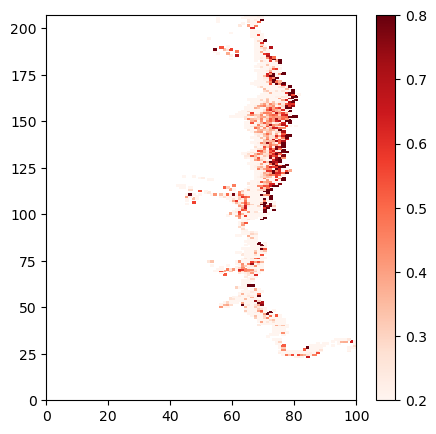

In [48]:
plt.figure(figsize=(5,5))
plt.pcolor(corrmap, cmap='Reds', vmin=0.2, vmax=0.8)
plt.colorbar()

# Shapley

In [ ]:
explainer = shap.DeepExplainer(model, X_train[700:710,:,:,:,:].flatten())
shap_values = explainer(X_test)